In [1]:
import csv
train, dev, test = [], [], []
with open('./data/pnli_train.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        train.append(x)
print (len(train))
print (train[:3])

with open('./data/pnli_dev.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        dev.append(x)
print (len(dev))
print (dev[:3])

with open('./data/pnli_test_unlabeled.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[0] and x[1] will be the sentence pairs.
        test.append(x)
print (len(test))
print (test[:3])

5983
[['Sometimes do exercise.', 'A person typically desire healthy life.', '1'], ['Who eats junk foods.', 'A person typically desire healthy life.', '0'], ['A person is sick.', 'A person typically desire healthy life.', '1']]
1055
[['A person is looking for accuracy.', 'A person typically desires accurate results.', '1'], ['A person does not care for accuracy.', 'A person typically desires accurate results.', '0'], ['The person double checks their data.', 'A person typically desires accurate results.', '1']]
4850
[['The people want to have a romantic and pleasant feel.', 'People typically does desire to smell violets.'], ['The contract is to buy products from you.', 'Getting contract typically cause to make money or spend money.'], ['Train station is closed.', 'Line can typically be used to move train along tracks.']]


In [2]:
result = []

In [3]:
import numpy as np

## **Main Body**

In [4]:
!pip install -q transformers
!pip install -q SentencePiece
!pip install -q datasets
!pip install -q torch

/opt/anaconda3/envs/c557/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

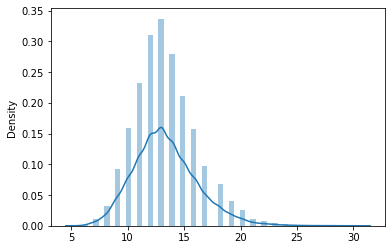

In [5]:
import seaborn as sns
len_sent = [ len(sample[0].split(" ")) + len(sample[1].split(" ")) for sample in train ]
sns.distplot(len_sent)

In [6]:
import torch
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [7]:
#MODEL_PATH = "roberta-base" #0.8729857819905213
#MODEL_PATH = "roberta-large" #0.8843601895734597
MODEL_PATH = 'cross-encoder/nli-deberta-v3-base' #0.9213270142180094
#MODEL_PATH = "cross-encoder/nli-deberta-v3-large" #memory error
#MODEL_PATH = "cross-encoder/nli-distilroberta-base" #0.86

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

OSError: Model name 'cross-encoder/nli-deberta-v3-base' was not found in tokenizers model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). We assumed 'cross-encoder/nli-deberta-v3-base' was a path or url to a directory containing vocabulary files named ['vocab.txt'] but couldn't find such vocabulary files at this path or url.

In [ ]:
def tokenize_function(examples):
    return tokenizer( examples['precondition'], examples['statement'], padding="max_length", return_token_type_ids=True, truncation=True)

In [ ]:
from datasets import Dataset, load_metric
train_data = Dataset.from_dict( { "precondition": [sample[0] for sample in train],
                           "statement": [sample[1] for sample in train],
                           "label": [int(sample[2]) for sample in train]} )

dev_data = Dataset.from_dict({ "precondition": [sample[0] for sample in dev],
                           "statement": [sample[1] for sample in dev],
                           "label": [int(sample[2]) for sample in dev]} )

train_data[100]

In [ ]:
tokenized_train_data = train_data.map(tokenize_function, batched=True)
tokenized_dev_data = dev_data.map(tokenize_function, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=3)

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_dev_data,
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: statement, precondition. If statement, precondition are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5983
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2244


Epoch,Training Loss,Validation Loss,Accuracy
1,0.416200,0.303359,0.897630
2,0.303700,0.304213,0.915640
3,0.113800,0.409357,0.921327


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: statement, precondition. If statement, precondition are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1055
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: statement, precondition. If statement, precondition are not expected by `DebertaV2ForSequenceC

TrainOutput(global_step=2244, training_loss=0.25301790832410737, metrics={'train_runtime': 2646.8058, 'train_samples_per_second': 6.781, 'train_steps_per_second': 0.848, 'total_flos': 4722707428807680.0, 'train_loss': 0.25301790832410737, 'epoch': 3.0})

In [ ]:
def generate_labels(model, encoded):
    labels =  []
    input_ids, attention_masks, token_type_ids = encoded["input_ids"], encoded["attention_mask"], encoded["token_type_ids"]
    n = len(input_ids)
    steps = 64
    with torch.no_grad():
      for i in range(0, n, steps):
          pred = model(torch.tensor(input_ids[i:i+steps]).to('cuda'), 
                       torch.tensor(attention_masks[i:i+steps]).to('cuda'), 
                       torch.tensor(token_type_ids[i:i+steps]).to('cuda')).logits
          labels.extend( list(np.argmax(pred.to('cpu').detach().numpy(), axis=1)) )
    return np.array(labels)

In [ ]:
pred = generate_labels(model, tokenized_dev_data)
print(np.unique(pred, return_counts = True))
def swap(p):
  if p == 2: return 1
  else: return p

pred = np.array([ swap(p) for p in pred ])
(pred == np.array(tokenized_dev_data['label'])).sum()/len(pred)

(array([0, 1]), array([498, 557]))


0.9213270142180094

In [20]:
test_data = Dataset.from_dict( { "precondition": [sample[0] for sample in test],
                           "statement": [sample[1] for sample in test]} )
tokenized_test_data = test_data.map(tokenize_function, batched=True)
results = generate_labels(model, tokenized_test_data)
results = np.array([swap(p) for p in results])

  0%|          | 0/5 [00:00<?, ?ba/s]

### Output Prediction Result File

In [21]:
# suppose you had your model's predictions on the 2028 test cases read from test_enc_unlabeled.tsv, and 
#those results are in the list called 'results'
assert (len(results) == 4850)

In [22]:
# make sure the results are not float numbers, but intergers 0 and 1
results = [int(x) for x in results]

In [23]:
# write your prediction results to 'upload_predictions.txt' and upload that later
with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
    for x in results:
        fp.write(str(x) + '\n')